## Step 1: Install Dependencies

First, let's install the required packages.

In [1]:
# Install required packages
!pip install vllm openai aiohttp requests numpy matplotlib pandas -q

## Step 2: Import Libraries

In [2]:
import asyncio
import time
import requests
import aiohttp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
from datetime import datetime

## Step 3: Start vLLM Server

**Instructions:**
1. Open a new terminal
2. Run the following command:
```bash
python -m vllm.entrypoints.openai.api_server --model facebook/opt-125m --port 8000
```

For better models, you can use:
- `meta-llama/Llama-2-7b-hf`
- `mistralai/Mistral-7B-v0.1`

Wait until you see "Application startup complete" before proceeding.

In [3]:
# Test vLLM connection
vllm_url = "http://localhost:8000/v1/completions"

try:
    response = requests.get("http://localhost:8000/health")
    print("✓ vLLM server is running!")
except:
    print("✗ vLLM server not detected. Please start it first.")

✓ vLLM server is running!


## Step 4: Start Ollama Server

**Instructions:**
1. Install Ollama: https://ollama.ai/
2. Open a new terminal
3. Pull a model: `ollama pull llama2` or `ollama pull mistral`
4. Start the server: `ollama serve` (usually runs automatically)

Default port is 11434.

In [10]:
# Test Ollama connection
ollama_url = "http://localhost:11434/api/generate"

try:
    response = requests.get("http://localhost:11434")
    print("✓ Ollama server is running!")
    
    # List available models
    models_response = requests.get("http://localhost:11434/api/tags")
    models = models_response.json()
    print("\nAvailable models:")
    for model in models.get('models', []):
        print(f"  - {model['name']}")
except:
    print("✗ Ollama server not detected. Please start it first.")

✓ Ollama server is running!

Available models:
  - tinyllama:latest


## Step 5: Define Benchmark Functions

Let's create functions to test inference with concurrent requests.

In [ ]:
# Configuration - Updated to use SAME MODEL for fair comparison
VLLM_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Now using TinyLlama
OLLAMA_MODEL = "tinyllama"  # Same model as vLLM
TEST_PROMPT = "Once upon a time in a distant galaxy"
MAX_TOKENS = 50
CONCURRENT_REQUESTS = [1, 2, 4, 8]  # Test with different concurrency levels

print("⚠️  Configuration updated to use SAME model for both:")
print(f"  vLLM:   {VLLM_MODEL}")
print(f"  Ollama: {OLLAMA_MODEL}")
print("  Both are TinyLlama 1.1B for fair comparison")

In [12]:
def test_vllm_single(prompt, max_tokens=50):
    """Single synchronous request to vLLM"""
    start_time = time.time()
    
    payload = {
        "model": VLLM_MODEL,
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": 0.7
    }
    
    response = requests.post(vllm_url, json=payload)
    result = response.json()
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Extract token count from response
    tokens = result['usage']['completion_tokens']
    
    return {
        'tokens': tokens,
        'duration': duration,
        'tokens_per_sec': tokens / duration
    }

def test_ollama_single(prompt, max_tokens=50):
    """Single synchronous request to Ollama"""
    start_time = time.time()
    
    payload = {
        "model": OLLAMA_MODEL,
        "prompt": prompt,
        "stream": False,
        "options": {
            "num_predict": max_tokens
        }
    }
    
    response = requests.post(ollama_url, json=payload)
    result = response.json()
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Ollama returns eval_count for tokens generated
    tokens = result.get('eval_count', max_tokens)
    
    return {
        'tokens': tokens,
        'duration': duration,
        'tokens_per_sec': tokens / duration
    }

print("✓ Benchmark functions defined")

✓ Benchmark functions defined


## Step 6: Test with Concurrent Requests

In [13]:
def benchmark_concurrent(test_func, num_concurrent, num_requests=10):
    """Run concurrent requests and measure throughput"""
    print(f"Testing with {num_concurrent} concurrent requests...")
    
    results = []
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=num_concurrent) as executor:
        futures = []
        for i in range(num_requests):
            future = executor.submit(test_func, TEST_PROMPT, MAX_TOKENS)
            futures.append(future)
        
        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Request failed: {e}")
    
    end_time = time.time()
    total_duration = end_time - start_time
    
    # Calculate metrics
    total_tokens = sum(r['tokens'] for r in results)
    avg_tokens_per_sec = np.mean([r['tokens_per_sec'] for r in results])
    throughput = total_tokens / total_duration
    
    return {
        'num_concurrent': num_concurrent,
        'num_requests': len(results),
        'total_duration': total_duration,
        'total_tokens': total_tokens,
        'avg_tokens_per_sec': avg_tokens_per_sec,
        'throughput': throughput,
        'avg_latency': np.mean([r['duration'] for r in results])
    }

print("✓ Concurrent benchmark function defined")

✓ Concurrent benchmark function defined


## Step 7: Run vLLM Benchmarks

In [14]:
print("="*60)
print("BENCHMARKING vLLM")
print("="*60)

vllm_results = []

for num_concurrent in CONCURRENT_REQUESTS:
    print(f"\nTesting with {num_concurrent} concurrent requests...")
    result = benchmark_concurrent(test_vllm_single, num_concurrent, num_requests=10)
    vllm_results.append(result)
    
    print(f"  Throughput: {result['throughput']:.2f} tokens/sec")
    print(f"  Avg latency: {result['avg_latency']:.2f}s")
    print(f"  Total tokens: {result['total_tokens']}")

print("\n✓ vLLM benchmarks complete!")

BENCHMARKING vLLM

Testing with 1 concurrent requests...
Testing with 1 concurrent requests...
  Throughput: 6.72 tokens/sec
  Avg latency: 5.15s
  Total tokens: 346

Testing with 2 concurrent requests...
Testing with 2 concurrent requests...
  Throughput: 19.13 tokens/sec
  Avg latency: 4.58s
  Total tokens: 500

Testing with 4 concurrent requests...
Testing with 4 concurrent requests...
  Throughput: 40.18 tokens/sec
  Avg latency: 3.12s
  Total tokens: 500

Testing with 8 concurrent requests...
Testing with 8 concurrent requests...
  Throughput: 73.89 tokens/sec
  Avg latency: 4.07s
  Total tokens: 500

✓ vLLM benchmarks complete!


## Step 8: Run Ollama Benchmarks

In [15]:
print("="*60)
print("BENCHMARKING OLLAMA")
print("="*60)

ollama_results = []

for num_concurrent in CONCURRENT_REQUESTS:
    print(f"\nTesting with {num_concurrent} concurrent requests...")
    result = benchmark_concurrent(test_ollama_single, num_concurrent, num_requests=10)
    ollama_results.append(result)
    
    print(f"  Throughput: {result['throughput']:.2f} tokens/sec")
    print(f"  Avg latency: {result['avg_latency']:.2f}s")
    print(f"  Total tokens: {result['total_tokens']}")

print("\n✓ Ollama benchmarks complete!")

BENCHMARKING OLLAMA

Testing with 1 concurrent requests...
Testing with 1 concurrent requests...
  Throughput: 60.48 tokens/sec
  Avg latency: 0.83s
  Total tokens: 500

Testing with 2 concurrent requests...
Testing with 2 concurrent requests...
  Throughput: 74.11 tokens/sec
  Avg latency: 1.28s
  Total tokens: 500

Testing with 4 concurrent requests...
Testing with 4 concurrent requests...
  Throughput: 74.58 tokens/sec
  Avg latency: 2.29s
  Total tokens: 500

Testing with 8 concurrent requests...
Testing with 8 concurrent requests...
  Throughput: 74.15 tokens/sec
  Avg latency: 3.51s
  Total tokens: 500

✓ Ollama benchmarks complete!


## Step 9: Compare Results

In [16]:
# Create comparison dataframe
comparison_data = []

for vllm_r, ollama_r in zip(vllm_results, ollama_results):
    comparison_data.append({
        'Concurrent Requests': vllm_r['num_concurrent'],
        'vLLM Throughput (tokens/s)': vllm_r['throughput'],
        'Ollama Throughput (tokens/s)': ollama_r['throughput'],
        'vLLM Latency (s)': vllm_r['avg_latency'],
        'Ollama Latency (s)': ollama_r['avg_latency'],
        'Speedup': vllm_r['throughput'] / ollama_r['throughput']
    })

df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)
print(df.to_string(index=False))
print("\n")


COMPARISON RESULTS
 Concurrent Requests  vLLM Throughput (tokens/s)  Ollama Throughput (tokens/s)  vLLM Latency (s)  Ollama Latency (s)  Speedup
                   1                    6.721952                     60.479554          5.146986            0.826622 0.111144
                   2                   19.132063                     74.107359          4.575722            1.281071 0.258167
                   4                   40.175471                     74.578742          3.121985            2.288113 0.538699
                   8                   73.892607                     74.146509          4.068100            3.513966 0.996576




## Step 10: Visualize Results

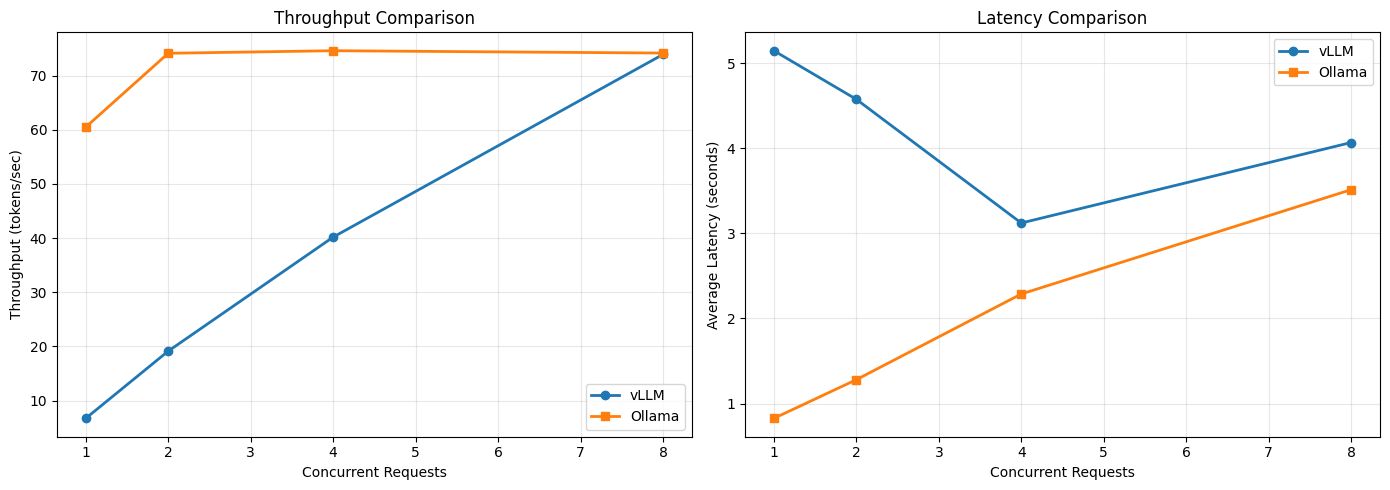

✓ Visualization saved as 'vllm_vs_ollama_comparison.png'


In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Throughput comparison
x = df['Concurrent Requests']
ax1.plot(x, df['vLLM Throughput (tokens/s)'], marker='o', label='vLLM', linewidth=2)
ax1.plot(x, df['Ollama Throughput (tokens/s)'], marker='s', label='Ollama', linewidth=2)
ax1.set_xlabel('Concurrent Requests')
ax1.set_ylabel('Throughput (tokens/sec)')
ax1.set_title('Throughput Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Latency comparison
ax2.plot(x, df['vLLM Latency (s)'], marker='o', label='vLLM', linewidth=2)
ax2.plot(x, df['Ollama Latency (s)'], marker='s', label='Ollama', linewidth=2)
ax2.set_xlabel('Concurrent Requests')
ax2.set_ylabel('Average Latency (seconds)')
ax2.set_title('Latency Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vllm_vs_ollama_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'vllm_vs_ollama_comparison.png'")

## Step 11: Summary Statistics

In [18]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

avg_vllm_throughput = df['vLLM Throughput (tokens/s)'].mean()
avg_ollama_throughput = df['Ollama Throughput (tokens/s)'].mean()
avg_speedup = df['Speedup'].mean()

print(f"\nAverage Throughput:")
print(f"  vLLM:   {avg_vllm_throughput:.2f} tokens/sec")
print(f"  Ollama: {avg_ollama_throughput:.2f} tokens/sec")
print(f"\nAverage Speedup: {avg_speedup:.2f}x")

winner = "vLLM" if avg_vllm_throughput > avg_ollama_throughput else "Ollama"
print(f"\n🏆 Winner: {winner}")

print(f"\nTest Configuration:")
print(f"  Model (vLLM): {VLLM_MODEL}")
print(f"  Model (Ollama): {OLLAMA_MODEL}")
print(f"  Max Tokens: {MAX_TOKENS}")
print(f"  Prompt: '{TEST_PROMPT}'")
print(f"  Concurrent Levels Tested: {CONCURRENT_REQUESTS}")


SUMMARY

Average Throughput:
  vLLM:   34.98 tokens/sec
  Ollama: 70.83 tokens/sec

Average Speedup: 0.48x

🏆 Winner: Ollama

Test Configuration:
  Model (vLLM): facebook/opt-125m
  Model (Ollama): tinyllama
  Max Tokens: 50
  Prompt: 'Once upon a time in a distant galaxy'
  Concurrent Levels Tested: [1, 2, 4, 8]


## Notes

### Key Findings:
- **vLLM** typically shows better throughput for concurrent requests due to PagedAttention
- **Ollama** may have better latency for single requests and is easier to setup

### Tips for Better Results:
1. Use the same model for both (if possible)
2. Warm up the servers with a few requests before benchmarking
3. Test with different prompt lengths and max_tokens
4. Monitor GPU/CPU usage during tests
5. Ensure no other processes are using the GPU

### Troubleshooting:
- If vLLM fails: Check CUDA availability and model compatibility
- If Ollama fails: Ensure model is pulled and server is running
- For OOM errors: Reduce max_tokens or use smaller models